# Introduction
The purpose of this notebook is to provide a clean and organized medium for performing an exploration into a [bitcoin dataset](https://www.kaggle.com/mczielinski/bitcoin-historical-data).  The goal of the exploration is to try and create a system that can correctly classify price change predictions of the cryptocurrency.  

As a template, I will be recreating the work of Amjad and Shah in their paper [Trading Bitcoin and Online Time Series Prediction](http://proceedings.mlr.press/v55/amjad16.pdf).

# Read In and Format Data

The daily closing price is read in from a CSV file.  Lines with NaN or unusual characters are removed.

In [73]:
import pandas as pd 
import datetime

def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

dataSetSize = 5000
data = pd.read_csv('btceUSD_1-min_data_FirstMillionPoints.csv', parse_dates=True, date_parser=dateparse, index_col=[0])
data = data[['Close']].apply(pd.to_numeric)
data = data.dropna()
data = data.head(dataSetSize)

print(data.head())
print('\nDataset Size:\t' + str(len(data.index.tolist())))

                     Close
Timestamp                 
2011-12-30 16:43:00  4.247
2011-12-30 19:01:00  4.100
2011-12-30 20:15:00  4.100
2011-12-30 21:27:00  4.044
2011-12-30 21:54:00  4.011

Dataset Size:	5000


# Plot the Time Series
We plot the time series to provide an initial visualization of the data.

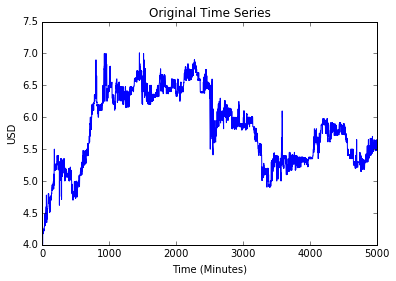

In [74]:
import pylab

pylab.plot([i for i in range(len(data['Close'].tolist()))], data['Close'].tolist())
pylab.xlabel('Time (Minutes)')
pylab.ylabel('USD')
pylab.title('Original Time Series')

# Test if Time Series is Stationary
Run Augmented Dickey-Fuller and KPSS tests to determine whether the time series is stationary.  ADF assumes non-stationarity as the null hypothesis, and KPSS assumes stationarity.  We will use an alpha value of 0.05.

In [75]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def testStationarity(inputData, alphs):
    
    # Augmented Dickey-Fuller Test
    # H0 is non-stationary
    results = adfuller(inputData)
    pValue = results[1]
    if pValue < alpha:
        print('ADF Result: \t Stationary' + '\t P-Value: \t' + str(pValue))
    else:
        print('ADF Result: \t Non-Stationary' + '\t P-Value: \t' + str(pValue))

    # Kwiatkowski-Phillips-Schmidt-Shin Test
    # H0 is stationary
    results = kpss(inputData)
    pValue = results[1]
    if pValue >= alpha:
        print('KPSS Result: \t Stationary' + '\t P-Value: \t' + str(pValue))
    else:
        print('KPSS Result: \t Non-Stationary' + '\t P-Value: \t' + str(pValue))

# Define alpha value for hypothesis testing
alpha = 0.05
testStationarity(data['Close'].values, alpha)

ADF Result: 	 Non-Stationary	 P-Value: 	0.0566969347193
KPSS Result: 	 Non-Stationary	 P-Value: 	0.01


C:\Anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1258: InterpolationWarning:

p-value is smaller than the indicated p-value



# Apply First-Differences to the Closing Price
Applying first-differences is when you transform the time series doing `data[t] = data[t] - data[t-1]`.  Differencing the time series in this way is a common method for achieving stationarity.

In [76]:
# Calculate different orders of difference in closing price
def calculateDifferences(data, numDifs):
    if numDifs == 0:
        keyColumn = 'Close'
    else:
        keyColumn = str(numDifs) + '_Dif'
    for i in range(1, numDifs+1):
        if i == 1:
            data[str(i) + '_Dif'] = data['Close'] - data['Close'].shift(1)
        else:
            data[str(i) + '_Dif'] = data[str(i-1) + '_Dif'] - data[str(i-1) + '_Dif'].shift(1)
    data = data.dropna()
    return data, keyColumn

numDifs = 1
data, keyColumn = calculateDifferences(data, numDifs)

print(data.head())

                     Close  1_Dif
Timestamp                        
2011-12-30 19:01:00  4.100 -0.147
2011-12-30 20:15:00  4.100  0.000
2011-12-30 21:27:00  4.044 -0.056
2011-12-30 21:54:00  4.011 -0.033
2011-12-30 22:22:00  4.218  0.207


# Test if Time Series (w/ First-Differences) is Stationary
Run Augmented Dickey-Fuller and KPSS tests to determine whether the time series is stationary.  ADF assumes non-stationarity as the null hypothesis, and KPSS assumes stationarity.  We will use an alpha value of 0.05.

In [77]:
testStationarity(data[keyColumn].values, alpha)

ADF Result: 	 Stationary	 P-Value: 	0.0
KPSS Result: 	 Stationary	 P-Value: 	0.1


C:\Anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



# Plot the Differenced Time Series
We will now plot the differenced time series, so we have a visualization of the transformation.

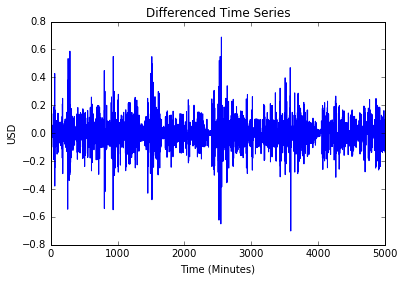

In [78]:
pylab.plot([i for i in range(len(data[keyColumn].tolist()))], data[keyColumn].tolist())
pylab.xlabel('Time (Minutes)')
pylab.ylabel('USD')
pylab.title('Differenced Time Series')

# Results So Far (1)
So far, we have read in the data for the daily closing price of bitcoin.  We found that the baseline dataset was not stationary, but that the differenced dataset was.  Now, we will try to visualize the differenced dataset using a histogram.

# Histogram of Time Series (w/ First-Differences)
We are plotting a histogram of the differenced time series to visualize whether the dataset appears to be Gaussian.

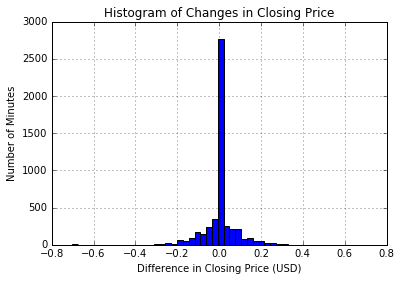

In [79]:
%matplotlib inline
hist = data[keyColumn].hist(bins=50)
hist.set_title("Histogram of Changes in Closing Price")
hist.set_xlabel("Difference in Closing Price (USD)")
hist.set_ylabel("Number of Minutes")

# QQ Plot of Time Series (w/ First-Differences)
We will make a QQ plot to get a better idea if the distribution is indeed Gaussian.  If the points fall (mostly) along a 45 degree red line, that will be a strong indicator that the distribution is Gaussian.

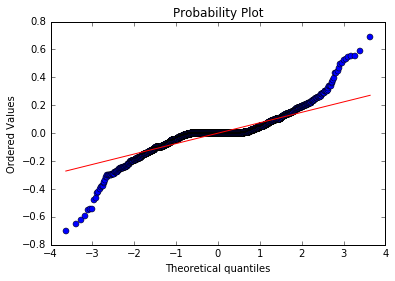

In [80]:
from scipy import stats
 
stats.probplot(data[keyColumn].values, dist='norm', plot=pylab)
pylab.show()

# Do KS Test to Determine if Time Series (w/ First-Differences) is Gaussian
The histogram and QQ plot seem to show that the time series not Guassian.  To be sure, we will run the Kolmogorov-Smirnov test to answer this question decisively, using an alpha value of 0.05.

In [81]:
# Kolmogorov-Smirnov Test
# H0 is that both distributions are identical
results = stats.kstest(data[keyColumn].values, 'norm')
pValue = results[1]
if pValue >= alpha:
    print('KS Result: \t Gaussian' + '\t P-Value: \t' + str(pValue))
else:
    print('KS Result: \t Non-Gaussian' + '\t P-Value: \t' + str(pValue))

KS Result: 	 Non-Gaussian	 P-Value: 	0.0


# Results So Far (2)
We have determined that the differenced time series is not a Gaussian distribution.  The QQ plot suggests that the differenced time series is a "thinner" distribution than the Gaussian.

# Plot the Autocorrelation / Partial Autocorrelation Functions
These plots will visualize the the dependence of the time series on the past.  We are hoping for two things:

1.  That the time series only depends on the recent past, as this implies mixing.
2.  That the time series show exponential decay, as this implies mixing.

A quote form the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot):

"If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero." 

The blue hilight region displayed in the plot corresponds to the 95% confidence bands.

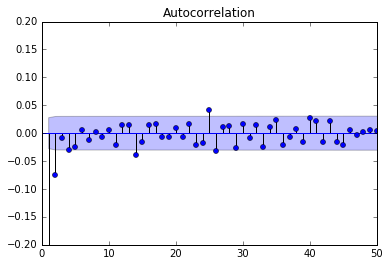

In [82]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as pyplot
plot_acf(data[keyColumn])
pylab.xlim([0, 50])
pylab.ylim([-0.2, 0.2])
pyplot.show()

## Partial Autocorrelaiton
Below is the code to run partial autocorrelation.  Do not do this unless you have time to spare, as it takes forever.  To improve runtime, I have taken the PACF of a subset (via `head()`) of the data.

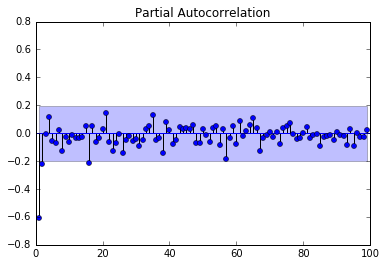

In [83]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data[keyColumn].head(100))
pylab.xlim([0, 100])
pylab.ylim([-0.8, 0.8])
pyplot.show()

# Results So Far (3)
We have plotted the autocorrelation and partial autocorrelation.  Both plots seem to imply that the very earliest lags are statistically significant.  Both plots seem to show that esponential-esque decay is occuring and that widely-separated times are asymptotically independent.  This implies mixing.

Next, we will add in the custom features specified by Amjad and Shah on page 6, and will form our feature vectors.

# Extracting Features & Forming Feature Vectors
Here, we will extract the three features described on pg. 6 of Amjad and Shah's paper.  These are:

1. The class of at data[t-1]
2. The tally count for each class in the past d time steps
3. The maximum consecutive run-length for each class in the past d time steps

In [84]:
from itertools import groupby

# Define the transaction fee (theta), and number of previous time steps to use (d)
theta = 0.000
d = 4

# Calculate the class at each timestamp
data['Class'] = data[keyColumn].apply(lambda x: 1 if x>theta else -1 if x<(-1*theta) else 0)

# Extract the class at data[t-1]
data['Previous_Class'] = data['Class'].shift(1)

# Extract the tally count for each class in the past d time steps
data['Class_-1_Tally'] = data['Class'].shift(1).rolling(window=d).apply(lambda x: sum([1 for i in x if i == -1]))
data['Class_0_Tally'] = data['Class'].shift(1).rolling(window=d).apply(lambda x: sum([1 for i in x if i == 0]))
data['Class_1_Tally'] = data['Class'].shift(1).rolling(window=d).apply(lambda x: sum([1 for i in x if i == 1]))

# Extract the maximum consecutive run-length for each classin the past d time steps
def getLongestRun(x, val):
    groupedX = [sum(1 for i in g) for k, g in groupby(x) if k == val]
    if groupedX == []:
        longestRun = 0
    else:
        longestRun = max(groupedX)
    return longestRun
data['Class_-1_Consec'] = data['Class'].shift(1).rolling(window=d).apply(lambda x: getLongestRun(x, -1))
data['Class_0_Consec'] = data['Class'].shift(1).rolling(window=d).apply(lambda x: getLongestRun(x, 0))
data['Class_1_Consec'] = data['Class'].shift(1).rolling(window=d).apply(lambda x: getLongestRun(x, 1))

# Clean the data
data = data[['Class', 'Previous_Class', 'Class_-1_Tally', 'Class_0_Tally', 'Class_1_Tally', 'Class_-1_Consec', 'Class_0_Consec', 'Class_1_Consec']]
data = data.dropna()

print(data.head())

                     Class  Previous_Class  Class_-1_Tally  Class_0_Tally  \
Timestamp                                                                   
2011-12-30 22:22:00      1            -1.0             3.0            1.0   
2011-12-30 22:41:00     -1             1.0             2.0            1.0   
2011-12-30 22:50:00      1            -1.0             3.0            0.0   
2011-12-30 23:04:00     -1             1.0             2.0            0.0   
2011-12-30 23:09:00      1            -1.0             2.0            0.0   

                     Class_1_Tally  Class_-1_Consec  Class_0_Consec  \
Timestamp                                                             
2011-12-30 22:22:00            0.0              2.0             1.0   
2011-12-30 22:41:00            1.0              2.0             1.0   
2011-12-30 22:50:00            1.0              2.0             0.0   
2011-12-30 23:04:00            2.0              1.0             0.0   
2011-12-30 23:09:00            2.0

# Create Training, Validation, and Test Set
It is now time to divide the data set into three pieces: a training, validation, and test set.  The data will be split into 60/20/20 proportions, as is common when using a validation set.

In [85]:
timestamps = data.index.tolist()

trainValSplit = timestamps[round(len(timestamps) * 0.6)]
valTestSplit = timestamps[round(len(timestamps) * 0.8)]

train = data.loc[:trainValSplit]
validation = data.loc[trainValSplit:valTestSplit]
test = data.loc[valTestSplit:]

print('Training Set Size: \t' + str(len(train)))
print('Validation Set Size: \t' + str(len(validation)))
print('Test Size: \t\t' + str(len(test)))

Training Set Size: 	2998
Validation Set Size: 	1000
Test Size: 		999


# Train the Classifiers
Now, we will train Logistic Regression and Random Forest classifiers.

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

y_train = train['Class'].values
X_train = train.drop(['Class'], axis=1).values

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Determine Threshold Quality Estimator
We now tune the parameter gamma, which represents the threshold confidence a classifier must have for its prediction to be considered.  Amjad and Shah note, quite brilliantly, that there is an inverse relationship between the accuracy of the classifiers, and the number of trades the classifier recommends.  Gamma should therefore be chosen to maximize the product of these two values.

In [87]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def getGammaByAccuracy(clf, clfName, X_val, y_val):
    y_pp = clf.predict_proba(X_val)
    results = []
    gammaRange = np.linspace(0, 1, num=100)
    for gamma in gammaRange:
        acceptedPredictionIndicies = [i for i in range(len(y_pp)) if (max(y_pp[i]) > gamma)]
            
        if acceptedPredictionIndicies != []:
            subX_val = [X_val[i] for i in acceptedPredictionIndicies]
            subY_val = [y_val[i] for i in acceptedPredictionIndicies]
                        
            # Parse out the instances where 0 was predicted
            subY_pred = clf.predict(subX_val)
            keepIndicies = [i for i in range(len(subY_pred)) if subY_pred[i] != 0]
            subY_pred_parsed = [subY_pred[i] for i in keepIndicies]
            subY_val_parsed = [subY_val[i] for i in keepIndicies]
            
            # Calculate Metrics
            accuracy = accuracy_score(subY_val_parsed, subY_pred_parsed)
            precision, recall, fscore, support = precision_recall_fscore_support(subY_val_parsed, subY_pred_parsed, labels=[-1, 0, 1])
            product = accuracy * len(acceptedPredictionIndicies)
            results.append((product, gamma, accuracy, len(acceptedPredictionIndicies), precision, recall, fscore, support))
            
        else:
            break
    product, gamma, accuracy, numPredictions, precision, recall, fscore, support = max(results)

    print('\n' + clfName + ' Results')
    print('Product: \t\t' + str(product))
    print('Gamma: \t\t\t' + str(gamma))
    print('Accuracy: \t\t' + str(accuracy)) 
    print('Num Predictions: \t' + str(numPredictions))
    print('Precision: \t\t' + str(precision)) 
    print('Recall: \t\t' + str(recall)) 
    print('F-Score: \t\t' + str(fscore)) 
    print('support: \t\t' + str(support)) 
    
    return gamma
    
y_val = validation['Class'].values
X_val = validation.drop(['Class'], axis=1).values

lrGamma = getGammaByAccuracy(lr, 'Logistic Regression', X_val, y_val)
rfGamma = getGammaByAccuracy(rf, 'Random Forest', X_val, y_val)

C:\Anaconda3\Lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Anaconda3\Lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.




Logistic Regression Results
Product: 		366.559485531
Gamma: 			0.343434343434
Accuracy: 		0.366559485531
Num Predictions: 	1000
Precision: 		[ 0.36700337  0.          0.36615385]
Recall: 		[ 0.58602151  0.          0.5862069 ]
F-Score: 		[ 0.45134576  0.          0.45075758]
support: 		[186 233 203]

Random Forest Results
Product: 		360.0
Gamma: 			0.353535353535
Accuracy: 		0.36
Num Predictions: 	1000
Precision: 		[ 0.35622318  0.          0.36239782]
Recall: 		[ 0.43005181  0.          0.665     ]
F-Score: 		[ 0.38967136  0.          0.4691358 ]
support: 		[193 207 200]


# Determine Threshold Quality Estimator (My Way)
Amjad and Shah sought to maximize the product of accuracy and the number of trades.  Accuracy is a risky metric to use for the goodness of a classifier, as it is not always reliable when classes are imbalanced.  For that reason, I believe a better metric to use would be the product of the precisions for class -1 and +1.  Using this figure rather than accuracy will guarentee that the gamma chosen will maximize the precision of our classifier on the relevant classes.

In [88]:
def getGammaByPrecision(clf, clfName, X_val, y_val):
    y_pp = clf.predict_proba(X_val)
    results = []
    gammaRange = np.linspace(0, 1, num=100)
    for gamma in gammaRange:
        acceptedPredictionIndicies = [i for i in range(len(y_pp)) if (max(y_pp[i]) > gamma)]
        if acceptedPredictionIndicies != []:
            subX_val = [X_val[i] for i in acceptedPredictionIndicies]
            subY_val = [y_val[i] for i in acceptedPredictionIndicies]
                        
            # Parse out the instances where 0 was predicted
            subY_pred = clf.predict(subX_val)
            keepIndicies = [i for i in range(len(subY_pred)) if subY_pred[i] != 0]
            subY_pred_parsed = [subY_pred[i] for i in keepIndicies]
            subY_val_parsed = [subY_val[i] for i in keepIndicies]
            
            # Calculate Metrics
            accuracy = accuracy_score(subY_val_parsed, subY_pred_parsed)
            precision, recall, fscore, support = precision_recall_fscore_support(subY_val_parsed, subY_pred_parsed, labels=[-1, 0, 1])
            product = precision[0] * precision[2] * len(acceptedPredictionIndicies)
            results.append((product, gamma, accuracy, len(acceptedPredictionIndicies), precision, recall, fscore, support))
            
        else:
            break
    product, gamma, accuracy, numPredictions, precision, recall, fscore, support = max(results)
    
    print('\n' + clfName + ' Results')
    print('Product: \t\t' + str(product))
    print('Gamma: \t\t\t' + str(gamma))
    print('Accuracy: \t\t' + str(accuracy)) 
    print('Num Predictions: \t' + str(numPredictions))
    print('Precision: \t\t' + str(precision)) 
    print('Recall: \t\t' + str(recall)) 
    print('F-Score: \t\t' + str(fscore)) 
    print('support: \t\t' + str(support)) 
    
    return gamma
    
y_val = validation['Class'].values
X_val = validation.drop(['Class'], axis=1).values

lrGamma = getGammaByPrecision(lr, 'Logistic Regression', X_val, y_val)
rfGamma = getGammaByPrecision(rf, 'Random Forest', X_val, y_val)

C:\Anaconda3\Lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Anaconda3\Lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.




Logistic Regression Results
Product: 		134.37969438
Gamma: 			0.343434343434
Accuracy: 		0.366559485531
Num Predictions: 	1000
Precision: 		[ 0.36700337  0.          0.36615385]
Recall: 		[ 0.58602151  0.          0.5862069 ]
F-Score: 		[ 0.45134576  0.          0.45075758]
support: 		[186 233 203]

Random Forest Results
Product: 		129.094502462
Gamma: 			0.353535353535
Accuracy: 		0.36
Num Predictions: 	1000
Precision: 		[ 0.35622318  0.          0.36239782]
Recall: 		[ 0.43005181  0.          0.665     ]
F-Score: 		[ 0.38967136  0.          0.4691358 ]
support: 		[193 207 200]


# Results So Far (4)
The results at this point are not looking good.  Both methods of selecting gamma appear to have yielded the same results.  My thoughts on these results are as follows:

- Accuracy: Neither Logistic Regression nor Random Forest was able to achieve an accuracy over 50%.
- Logistic Regression: This classifier is has reasonable recall for each class, but poor precision.
- Random Forest: This classifier has poor precision, and a recall that clearly favors the +1 class.

# Results on Test Set
Now, we will run our trained classifiers on the test set.  In evaluating the classifiers, we will calculate the classification accuracy as Amjad and Shah did.  Additionally, we will calculate the precision, recall, and F-score, as these metrics provide a more complete picture of the classifier's performance.

In [89]:
def testPerformance(clf, gamma, clfName, X_test, y_test, timestamps):
    
    # Parse out predicitons that don't meet gamma value
    y_pp = clf.predict_proba(X_test)
    acceptedPredictionIndicies = [i for i in range(len(y_pp)) if (max(y_pp[i]) > gamma)]
    subX_test = [X_test[i] for i in acceptedPredictionIndicies]
    subY_test = [y_test[i] for i in acceptedPredictionIndicies]
    subTimestamps = [timestamps[i] for i in acceptedPredictionIndicies]
    
    # Parse out the instances where 0 was predicted
    subY_pred = clf.predict(subX_test)
    keepIndicies = [i for i in range(len(subY_pred)) if subY_pred[i] != 0]
    subY_pred_parsed = [subY_pred[i] for i in keepIndicies]
    subY_test_parsed = [subY_test[i] for i in keepIndicies]
    subTimestamps_parsed = [subTimestamps[i] for i in keepIndicies]
    
    # Calculate Metrics
    accuracy = accuracy_score(subY_test_parsed, subY_pred_parsed)
    precision, recall, fscore, support = precision_recall_fscore_support(subY_test_parsed, subY_pred_parsed)

    # Print Metrics
    print('\n' + clfName + ' Results')
    print('Accuracy: \t\t' + str(accuracy))
    print('Precision: \t\t' + str(precision))
    print('Recall: \t\t' + str(recall)) 
    print('F-Score: \t\t' + str(recall))
    print('Support: \t\t' + str(support))
    
    # Return predictions, true classes, and timestamps
    return (subY_pred_parsed, subY_test_parsed, subTimestamps_parsed)

timestamps = test.index.tolist()
y_test = test['Class'].values
X_test = test.drop(['Class'], axis=1).values

lrResults = testPerformance(lr, lrGamma, 'Logistic Regression', X_test, y_test, timestamps)
rfResults = testPerformance(rf, rfGamma, 'Random Forest', X_test, y_test, timestamps)


Logistic Regression Results
Accuracy: 		0.351081530782
Precision: 		[ 0.33217993  0.          0.36858974]
Recall: 		[ 0.49740933  0.          0.56930693]
F-Score: 		[ 0.49740933  0.          0.56930693]
Support: 		[193 206 202]

Random Forest Results
Accuracy: 		0.343548387097
Precision: 		[ 0.31578947  0.          0.36193029]
Recall: 		[ 0.40414508  0.          0.625     ]
F-Score: 		[ 0.40414508  0.          0.625     ]
Support: 		[193 211 216]


C:\Anaconda3\Lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



# Conclusion
When it came to the test set, the results were unimpressive.  Both classifiers have poor precision and accuracy.  The best attribute present is the recall of Logistic Regression, which sadly dipped below 50% for the -1 class.  All things considered, I believe this shows that the [results](http://proceedings.mlr.press/v55/amjad16.pdf) of Amjad and Shah were not reproducable.